Keys in the file: ['ismrmrd_header', 'kspace', 'reconstruction_rss']

Key: ismrmrd_header
  Shape: ()
  Dtype: object

Key: kspace
  Shape: (16, 20, 640, 320)
  Dtype: complex64

Key: reconstruction_rss
  Shape: (16, 320, 320)
  Dtype: float32

k-space sample shape: (16, 20, 640, 320)
k-space sample dtype: complex64
k-space slice 0 mean (real): 1.1885286e-09
k-space slice 1 mean (real): -3.5125896e-09


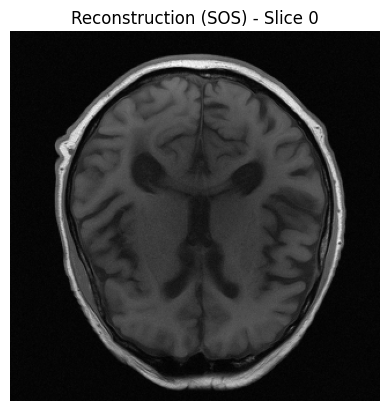

In [14]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 文件路径（请确保路径正确）
file_path = '../data/file_brain_AXT1PRE_200_6002128.h5'

# 打开 HDF5 文件
with h5py.File(file_path, 'r') as f:
    # 列出顶层结构（通常是键）
    print("Keys in the file:", list(f.keys()))

    # 查看每个 key 的数据维度和类型
    for key in f.keys():
        data = f[key]
        print(f"\nKey: {key}")
        print(f"  Shape: {data.shape}")
        print(f"  Dtype: {data.dtype}")

    # 示例读取 kspace（如果有）
    if 'kspace' in f:
        kspace = f['kspace'][:]
        print("\nk-space sample shape:", kspace.shape)
        print("k-space sample dtype:", kspace.dtype)

        # 打印前两个 slice 的实部均值作为示例
        print("k-space slice 0 mean (real):", np.mean(np.real(kspace[0])))
        print("k-space slice 1 mean (real):", np.mean(np.real(kspace[1])))
        img_rss = f['reconstruction_rss'][0]  # 第 0 个切片

plt.imshow(img_rss, cmap='gray')
plt.title("Reconstruction (SOS) - Slice 0")
plt.axis('off')
plt.show()

In [ ]:
#!pip install matplotlib numpy h5py scikit-image --break-system-packages

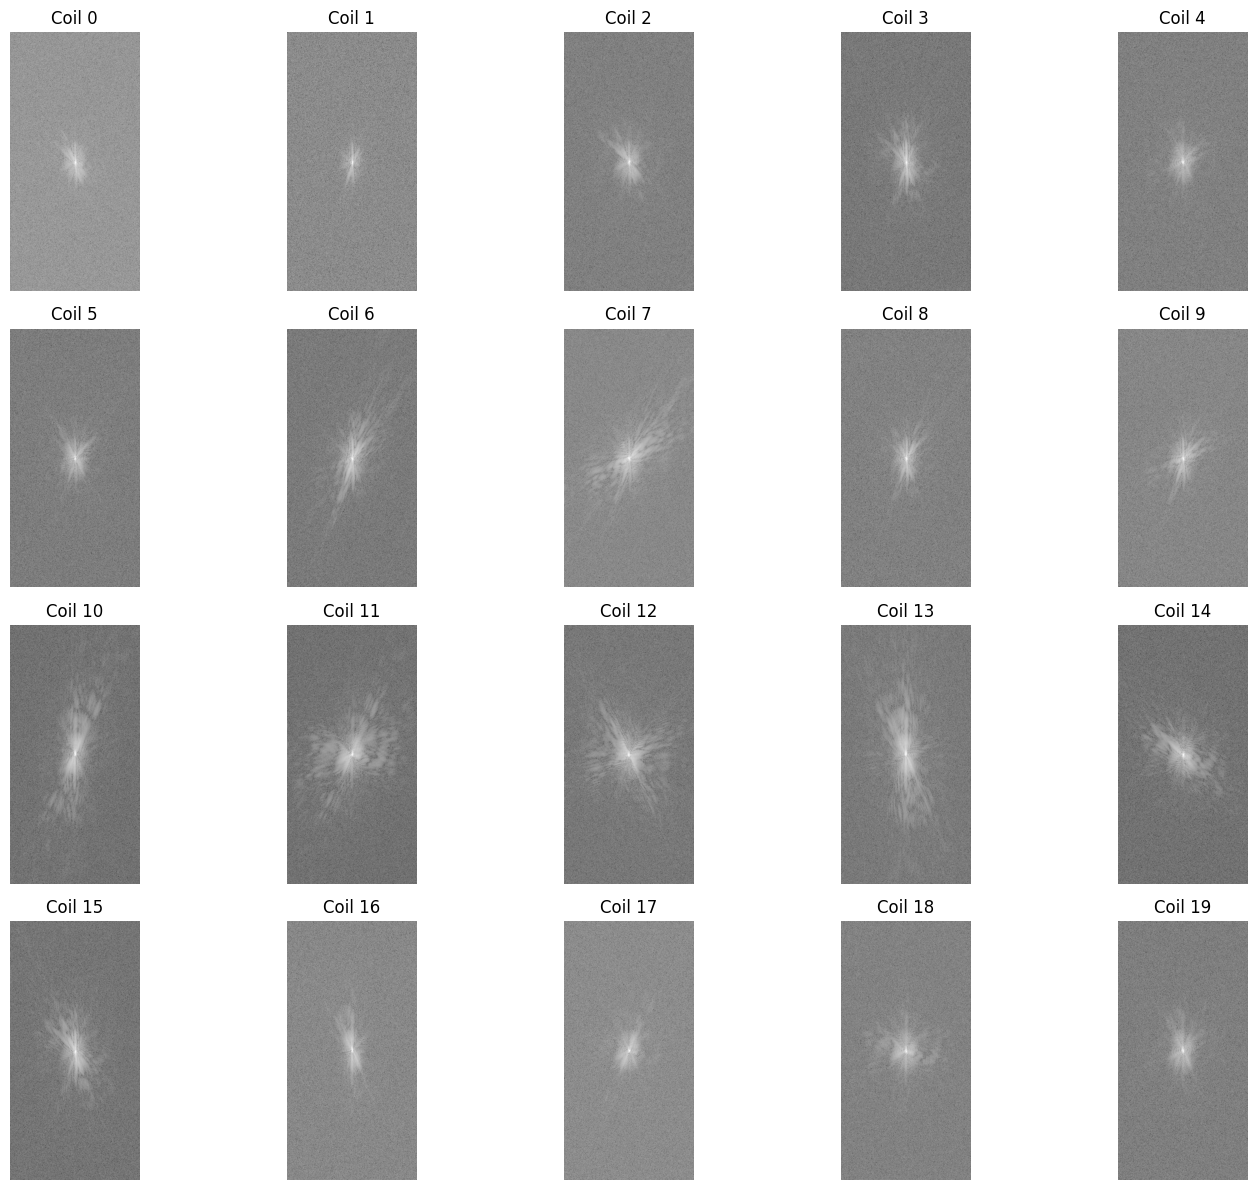

In [7]:
# 打开并读取 k-space 数据
with h5py.File(file_path, 'r') as f:
    kspace = f['kspace'][()]  # shape 可能是 (slices, coils, h, w) 或 (coils, h, w)

# 只取第一个 slice，如果有 slice 维度
if kspace.ndim == 4:
    kspace = kspace[0]  # shape: (20, h, w)

num_coils = kspace.shape[0]
assert num_coils == 20, f"发现了 {num_coils} 个coil，不是20个，请检查数据结构"

# 创建 4 行 5 列的子图
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i in range(20):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    
    # 计算 magnitude 并 log 缩放增强可视化
    magnitude = np.log(np.abs(kspace[i]) + 1e-9)
    ax.imshow(magnitude, cmap='gray')
    ax.set_title(f'Coil {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


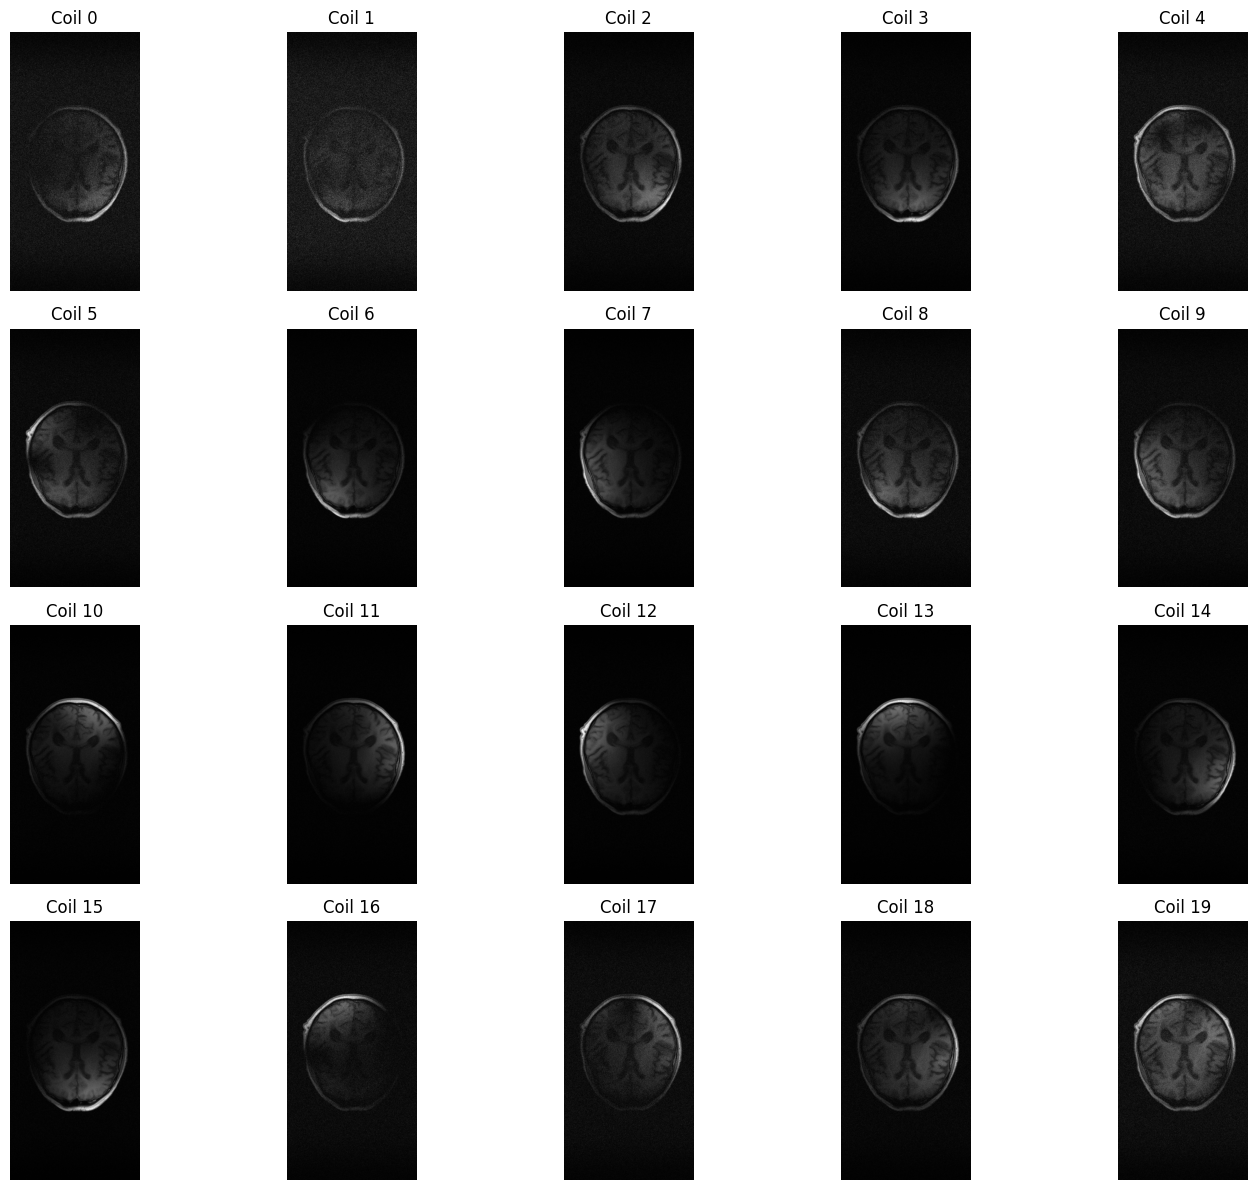

In [8]:
# 读取k-space数据
with h5py.File(file_path, 'r') as f:
    kspace = f['kspace'][()]  # 可能 shape: (slices, coils, h, w) 或 (coils, h, w)

# 如果是4维，取第一个slice
if kspace.ndim == 4:
    kspace = kspace[0]  # shape: (20, h, w)

num_coils = kspace.shape[0]

# 对每个 coil 做 2D ifft
images = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(kspace, axes=(-2, -1)), norm='ortho'), axes=(-2, -1))

# 取 magnitude 图像
image_magnitudes = np.abs(images)

# 可视化：每个coil一幅图像
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i in range(num_coils):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    ax.imshow(image_magnitudes[i], cmap='gray')
    ax.set_title(f'Coil {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


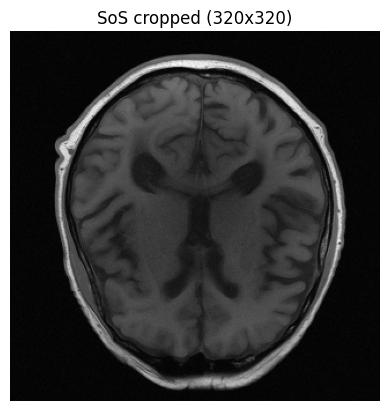

In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def center_crop(image, crop_size):
    h, w = image.shape
    ch, cw = crop_size
    start_h = (h - ch) // 2
    start_w = (w - cw) // 2
    return image[start_h:start_h+ch, start_w:start_w+cw]

# Step 1: Load fastMRI k-space data
file_path = '../data/file_brain_AXT1PRE_200_6002128.h5'

with h5py.File(file_path, 'r') as f:
    kspace = f['kspace'][()]  # Shape: (slices, coils, h, w)

# Step 2: Choose one slice
kspace_slice = kspace[0]  # Shape: (coils, 640, 320)

# Step 3: Per-coil 2D IFFT → complex image
coil_images = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(kspace_slice, axes=(-2, -1)), norm='ortho'), axes=(-2, -1))

# Step 4: Get magnitude
magnitudes = np.abs(coil_images)

# Step 5: Compute Sum-of-Squares (SoS)
sos_image = np.sqrt(np.sum(magnitudes**2, axis=0))  # Shape: (640, 320)

# Step 6: Center crop to 320x320
sos_cropped = center_crop(sos_image, (320, 320))

# Optional: Normalize to [0, 1]
sos_cropped = sos_cropped / np.max(sos_cropped)

# Step 7: Visualize
plt.imshow(sos_cropped, cmap='gray')
plt.title('SoS cropped (320x320)')
plt.axis('off')
plt.show()

# Optional: Save for training
# np.save('sos_image_320x320.npy', sos_cropped)


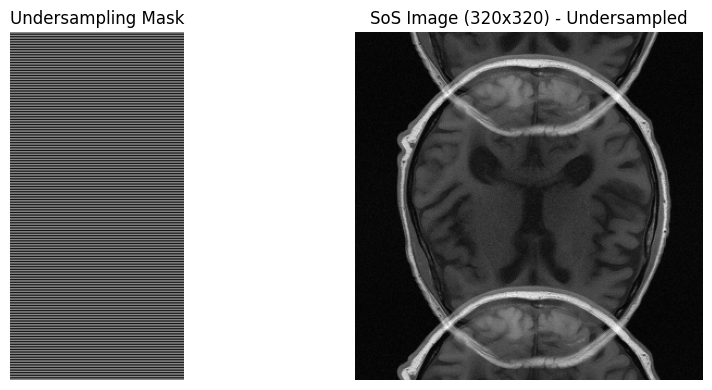

In [15]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def center_crop(image, crop_size):
    h, w = image.shape
    ch, cw = crop_size
    start_h = (h - ch) // 2
    start_w = (w - cw) // 2
    return image[start_h:start_h+ch, start_w:start_w+cw]

# Step 1: Load fastMRI k-space data
file_path = '../data/file_brain_AXT1PRE_200_6002128.h5'

with h5py.File(file_path, 'r') as f:
    kspace = f['kspace'][()]  # Shape: (slices, coils, h, w)

# Step 2: Choose one slice
kspace_slice = kspace[0]  # Shape: (coils, 640, 320)

# Step 3: Create undersampling mask: keep every 3rd line in phase-encoding direction (height)
mask = np.zeros(kspace_slice.shape[1:], dtype=bool)  # Shape: (640, 320)
mask[::3, :] = True  # keep every 3rd row

# Step 4: Apply undersampling mask to each coil
kspace_under = kspace_slice * mask[None, :, :]  # shape: (coils, 640, 320)

# Step 5: Per-coil 2D IFFT → complex image
coil_images = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(kspace_under, axes=(-2, -1)), norm='ortho'), axes=(-2, -1))

# Step 6: Get magnitude
magnitudes = np.abs(coil_images)

# Step 7: Compute Sum-of-Squares (SoS)
sos_image = np.sqrt(np.sum(magnitudes**2, axis=0))  # Shape: (640, 320)

# Step 8: Center crop to 320x320
sos_cropped = center_crop(sos_image, (320, 320))

# Optional: Normalize to [0, 1]
sos_cropped = sos_cropped / np.max(sos_cropped)

# Step 9: Visualize
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.title('Undersampling Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sos_cropped, cmap='gray')
plt.title('SoS Image (320x320) - Undersampled')
plt.axis('off')

plt.tight_layout()
plt.show()


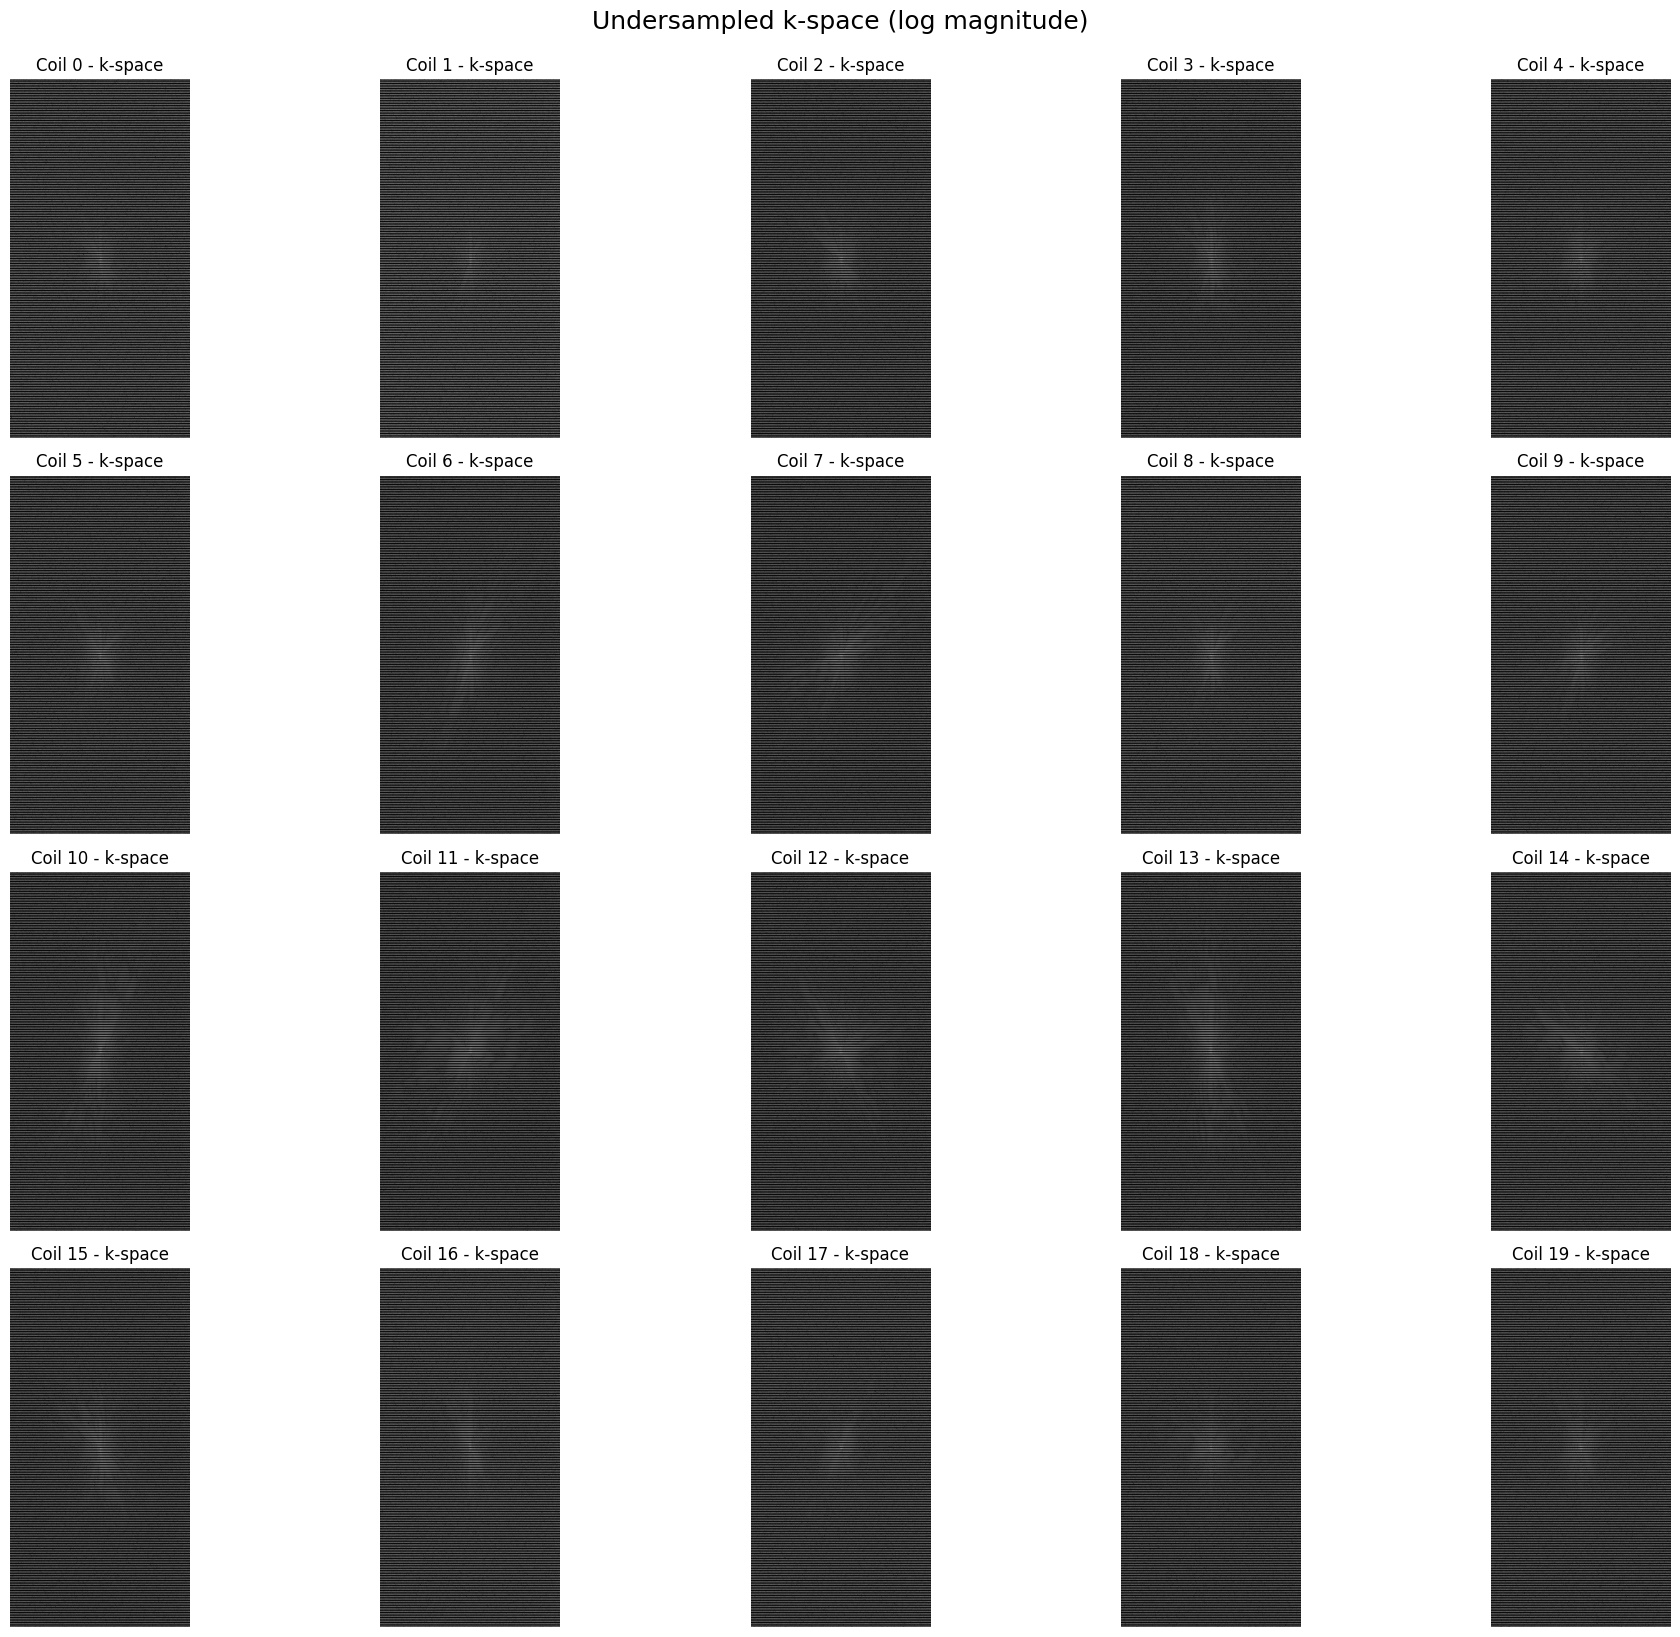

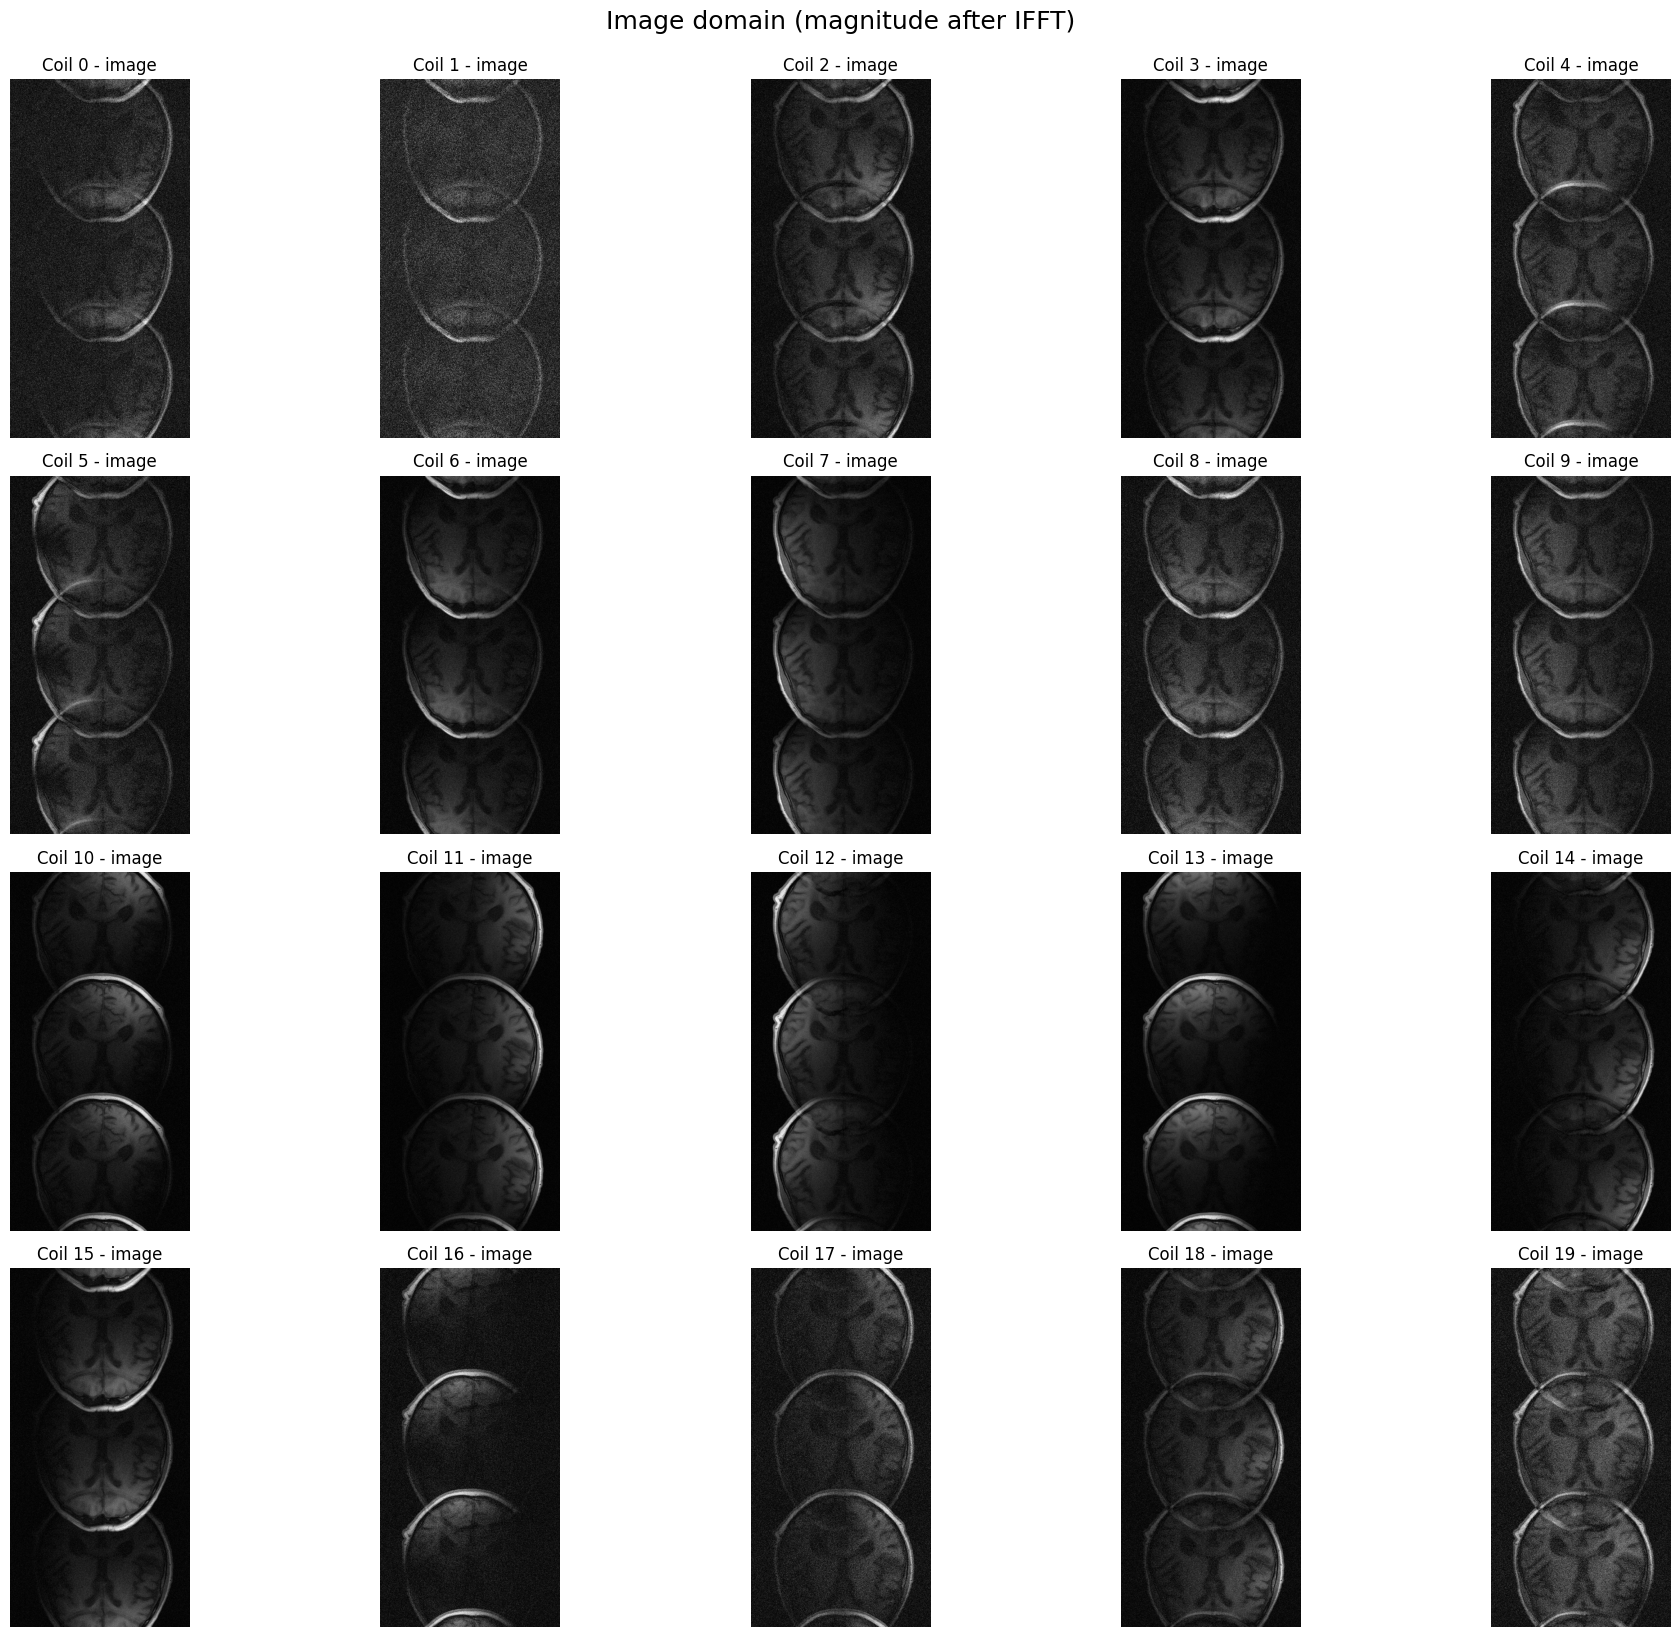

In [18]:
import matplotlib.pyplot as plt
import numpy as np

num_coils = kspace_under.shape[0]
cols = 5
rows = 4

# ----------- 1. 显示每个线圈的 k-space 图像（log） -----------
plt.figure(figsize=(4 * cols, 4 * rows))
for i in range(num_coils):
    k_under = np.log(np.abs(kspace_under[i]) + 1e-9)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(k_under, cmap='gray')
    plt.title(f'Coil {i} - k-space')
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Undersampled k-space (log magnitude)", fontsize=18, y=1.02)
plt.show()

# ----------- 2. 显示每个线圈的图像域图像（ifft） -----------
plt.figure(figsize=(4 * cols, 4 * rows))
for i in range(num_coils):
    img = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(kspace_under[i], axes=(-2, -1)), norm='ortho'))
    img_abs = np.abs(img)
    img_abs /= np.max(img_abs)  # normalize for consistent brightness
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_abs, cmap='gray')
    plt.title(f'Coil {i} - image')
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Image domain (magnitude after IFFT)", fontsize=18, y=1.02)
plt.show()
